<br>

## Week 5 - Classification with Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA)

Welcome to the Week 5 Lab Session on Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA). In this lab, we will explore these discriminant analysis classification methods using the `tidyverse` and `tidymodels` packages in R. 

Both LDA and QDA are used for classifying data, but they differ in their assumptions and flexibility. LDA assumes linear decision boundaries, while QDA allows for quadratic boundaries, providing more flexibility in modeling complex relationships.


### The Dataset

For this week's lab, we will use the Default dataset from the ISLR (Introduction to Statistical Learning with R) book. This dataset contains information on whether an individual defaults on their credit card payment along with predictors such as income, balance, and student status. 

### Metadata

__default:__ Indicates whether the individual defaulted on their credit card payment, (Yes, No)  <br>
__student:__ Indicates whether the individual is a student. (Yes, No) <br>
__balance:__ The balance on the individual's credit card. <br>
__income:__ The individual's annual income. 


### Importing the Dataset

There are a few options to import the dataset. You may use the `ISLR` packages and load the data directly. You can also find the dataset within our `Datasets` folder and read it as a `.csv` file. Below we use the latter option.

<br>

<div class="alert alert-block alert-info" style="background-color:white" >

__Because we have already conducted some initial data analysis with Logistic Regression, we proceed directly with developing the LDA model.__
</div>

<br>

In [1]:
# Loading the necessary packages
# install.packages( c('discrim') )
library(tidyverse)
library(tidymodels)
library(parsnip)
library(discrim)
library(ggthemr)

# setting up the theme
ggthemr('fresh')

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
-- Attaching packages -------------------------------------- tidymodels 1.2.0 --

v broom        1.0.7     v rsample      1.2.1
v dials        1.3.0     v tune         1.2.1
v infer        1.0.7     v workflows    1.1.4
v modeldata    1.4.0     v workflowsets 1.1.0
v parsnip      1.2.1     v yardstick    1.3.1
v recipes      1.1.0     

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filt

In [2]:
credit_data <- read.csv('Datasets/Default.csv')
credit_data <- as_tibble(credit_data)

slice_head(credit_data, n = 8)

X...default,student,balance,income
<chr>,<chr>,<dbl>,<dbl>
No,No,729.5265,44361.625
No,Yes,817.1804,12106.135
No,No,1073.5492,31767.139
No,No,529.2506,35704.494
No,No,785.6559,38463.496
No,Yes,919.5885,7491.559
No,No,825.5133,24905.227
No,Yes,808.6675,17600.451


In [3]:
dim(credit_data)

[1] 10000     4

<br>

### Data Preparation for Modelling

In the previous discussions, we have learned about splitting the dataset ahead of a modeling task. This section covers the preparation we need. Before we split the data, we must convert the `default` and `student` into factors inorder to make the eligible as inputs to the model.

__Changing Categorical Variables into Factors__

In [4]:
# changing categorical variables into factors
credit_data <- credit_data %>%
                rename( default = X...default ) %>%
                mutate( default = as.factor(default),
                        student = as.factor(default))

<br>

## __Splitting the dataset into Train and Test__

We can now go ahead and split the data into train and test groups.

In [5]:
# for reproducibility
set.seed(514)

# setting the split model
data_split = initial_split( credit_data, prop = .8, strata = 'default' )

# splitting the dataset
train_data = training(data_split)
test_data = testing(data_split)

Warning message:
"The `scale_name` argument of `discrete_scale()` is deprecated as of ggplot2
3.5.0."


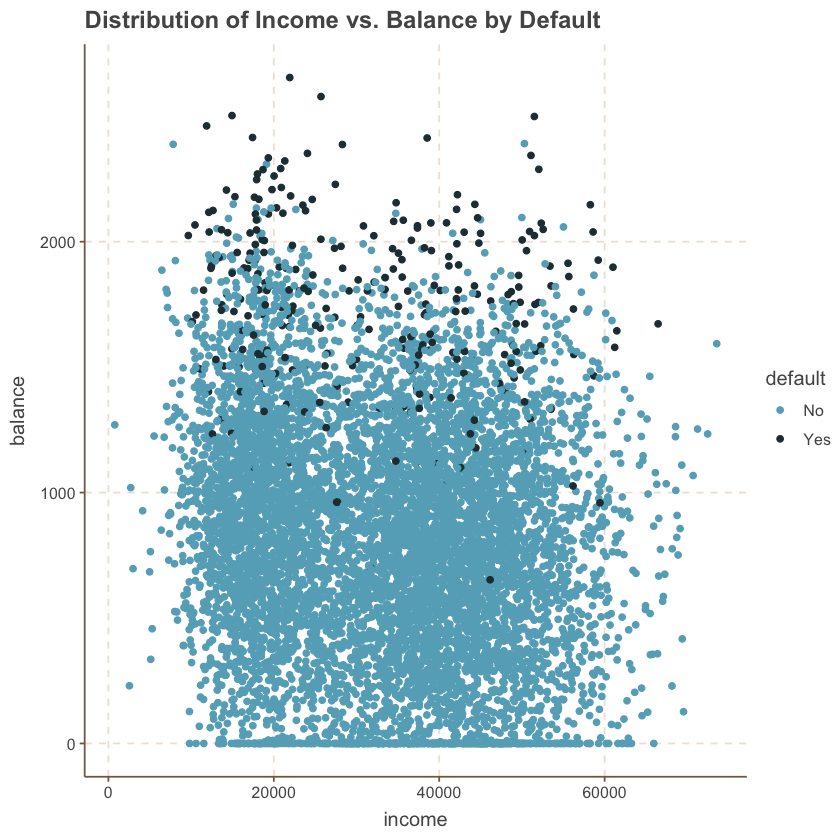

In [6]:
ggplot(data = train_data, aes(x = income, y = balance, color = default)) +
    geom_point() +
    labs(title = 'Distribution of Income vs. Balance by Default')

<br>

## Building the Linear Discriminant Analysis

In this section, we will demonstrate how to build and evaluate a Linear Discriminant Analysis (LDA) model using the `tidyverse` and `tidymodels` packages in R. LDA is a powerful method for classification, especially useful when the assumption of normally distributed data and homoscedasticity holds true.

In [7]:
lda_spec <- discrim_linear() %>%
            # Set the mode to classification
            set_mode("classification") %>%
            # Set the engine to 'MASS' for performing LDA
            set_engine("MASS")

In [8]:
lda_fit <- lda_spec %>% fit(formula = default ~ income + balance, data = train_data)

lda_fit

parsnip model object

Call:
lda(default ~ income + balance, data = data)

Prior probabilities of groups:
      No      Yes 
0.965625 0.034375 

Group means:
      income  balance
No  33543.98  809.748
Yes 31729.88 1756.309

Coefficients of linear discriminants:
                 LD1
income  7.173762e-06
balance 2.222733e-03

<div class="alert alert-block alert-info" style="background-color:white" >
Linear Discriminant Function (LD1):
The LDA model creates a linear combination of the predictors to form a discriminant score (LD1) that best separates the classes. 

The formula for LD1 based on your coefficients is:

$ LD1 = (7.173762 \times 10^{-6}) \times \text{income} + (2.222733 \times 10^{-3}) \times \text{balance} $

Coefficient Magnitudes: <br>
•	Income: The coefficient for income is 7.173762e-06, which is quite small. <br>
•	Balance: The coefficient for balance is 2.222733e-03, which is larger compared to income. <br>
</div>

<br>

### Assessing the LDA Classifier

With the model created, we can proceed with the classification assessment. Specifically, develop a confusion matrix and visualize it. Further, we will produce additional metrics to further understand how our model performs.

In [9]:
# confusion matrix
augment( lda_fit, new_data = train_data) %>%
         conf_mat( truth = default, estimate = .pred_class ) 

          Truth
Prediction   No  Yes
       No  7710  212
       Yes   15   63

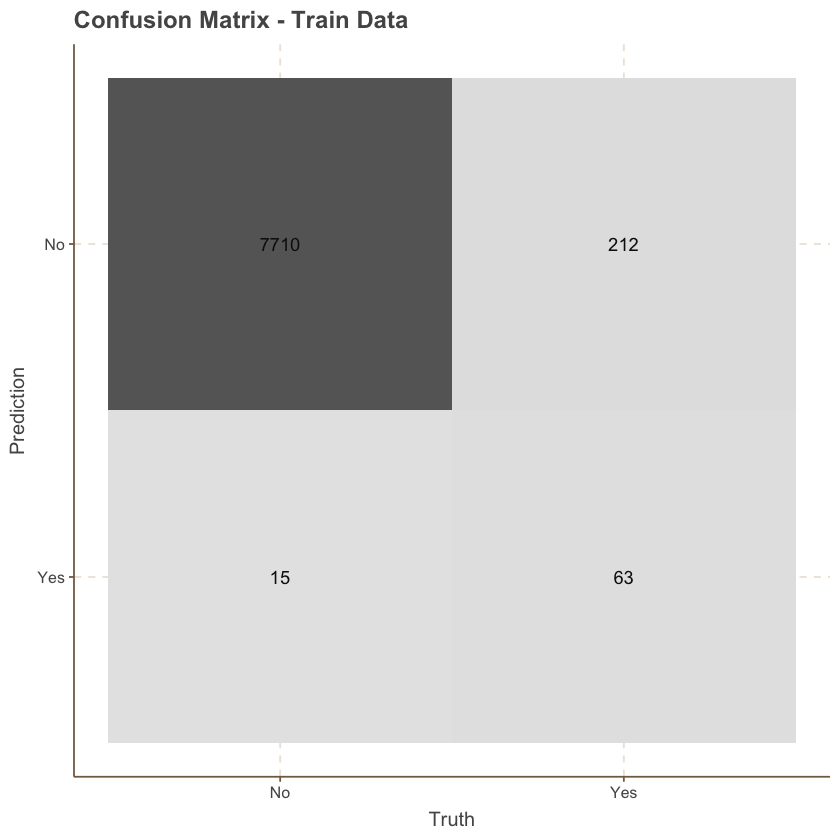

In [10]:
# confusion matrix
augment( lda_fit, new_data = train_data) %>%
         conf_mat( truth = default, estimate = .pred_class ) %>%
         autoplot( type = 'heatmap' ) +
         labs(title = 'Confusion Matrix - Train Data')

<br>

### Additional Metrics for the Classifier

We can now use the following code to computer additional metrics to assess other elements of the model performance.

In [11]:
augment( lda_fit, new_data = train_data ) %>% 
    summarise(
               accuracy = mean( .pred_class == default),
               sensitivity = sens_vec(truth = default, estimate = .pred_class),
               specificity = spec_vec(truth = default, estimate = .pred_class),
               precision = precision_vec(truth = default, estimate = .pred_class),
               recall = recall_vec(truth = default, estimate = .pred_class),
               f1 = f_meas_vec(truth = default, estimate = .pred_class)
)

accuracy,sensitivity,specificity,precision,recall,f1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.971625,0.9980583,0.2290909,0.9732391,0.9980583,0.9854924


<br>

### Running Prediction on Test Data 

Our model has performed relatively well across all metrics. Let's now see how the model performs on the test set.

In [12]:
# confusion matrix
augment( lda_fit, new_data = test_data) %>%
         conf_mat( truth = default, estimate = .pred_class ) 

          Truth
Prediction   No  Yes
       No  1938   46
       Yes    4   12

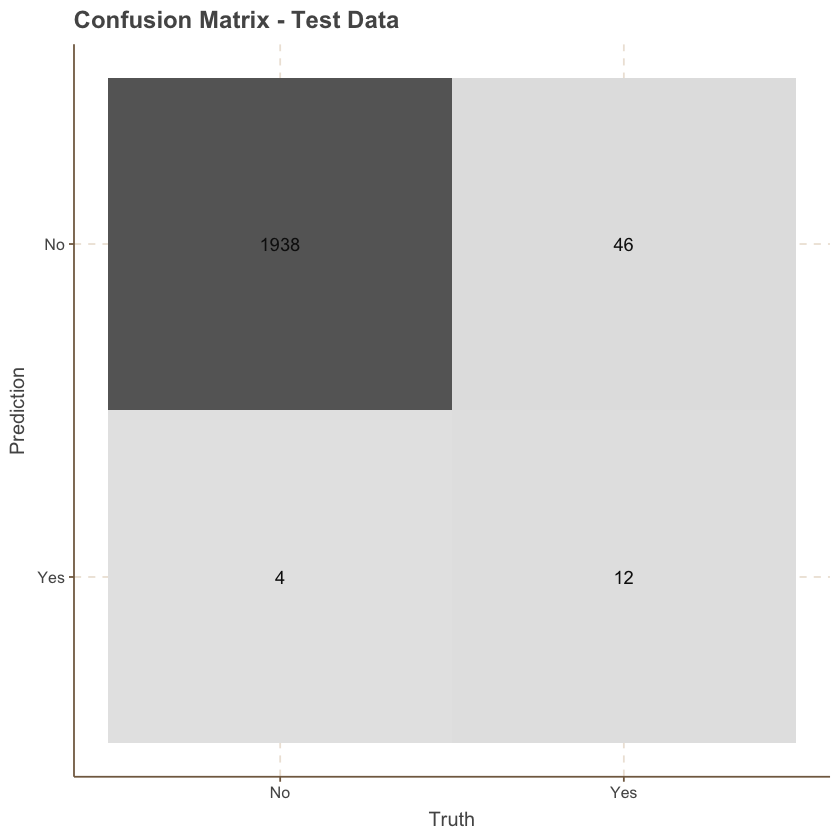

In [13]:
# confusion matrix for the test data
augment( lda_fit, new_data = test_data) %>%
         conf_mat( truth = default, estimate = .pred_class ) %>%
         autoplot( type = 'heatmap' ) + 
         labs(title = 'Confusion Matrix - Test Data')

In [14]:
augment( lda_fit, new_data = test_data ) %>% 
    summarise(
               accuracy = mean( .pred_class == default),
               sensitivity = sens_vec(truth = default, estimate = .pred_class),
               specificity = spec_vec(truth = default, estimate = .pred_class),
               precision = precision_vec(truth = default, estimate = .pred_class),
               recall = recall_vec(truth = default, estimate = .pred_class),
               f1 = f_meas_vec(truth = default, estimate = .pred_class)
)

accuracy,sensitivity,specificity,precision,recall,f1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.975,0.9979403,0.2068966,0.9768145,0.9979403,0.9872644


<br>

## Building a Quadratic Discriminant Analysis Model

Quadratic Discriminant Analysis (QDA) is a powerful statistical technique used in machine learning and pattern recognition for classification tasks. As an extension of Linear Discriminant Analysis (LDA), QDA offers a more flexible approach to decision boundaries, making it particularly useful when dealing with complex datasets where class distributions exhibit different covariance structures.

In the this section, we explore that technical implementation of `QDA` using the `discrim_quad()` function. We will continue using the same dataset we have used for `LDA` 

In [15]:
# defining the model 
qda_model <- discrim_quad() %>%
              set_mode("classification") %>%
              set_engine("MASS")

# computing the fit of the model
qda_fit <- qda_model %>% 
            fit(formula = default ~ income + balance, data = train_data)

qda_fit

parsnip model object

Call:
qda(default ~ income + balance, data = data)

Prior probabilities of groups:
      No      Yes 
0.965625 0.034375 

Group means:
      income  balance
No  33543.98  809.748
Yes 31729.88 1756.309

<br>

## Model Assessment and Accuracy Measurement

The construction of the model is fairly straight forward. In the same way, we constructed it with `LDA`, we can now construct the confusion metrics that will help us gauge how the model is performing.  

In [16]:
augment(qda_fit, new_data = test_data) %>%
  conf_mat(truth = default, estimate = .pred_class)

          Truth
Prediction   No  Yes
       No  1936   44
       Yes    6   14

In [17]:
augment(qda_fit, new_data = test_data) %>%
  accuracy(truth = default, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.975


In [18]:
augment( qda_fit, new_data = test_data ) %>% 
    summarise(
               accuracy = mean( .pred_class == default),
               sensitivity = sens_vec(truth = default, estimate = .pred_class),
               specificity = spec_vec(truth = default, estimate = .pred_class),
               precision = precision_vec(truth = default, estimate = .pred_class),
               recall = recall_vec(truth = default, estimate = .pred_class),
               f1 = f_meas_vec(truth = default, estimate = .pred_class)
)

accuracy,sensitivity,specificity,precision,recall,f1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.975,0.9969104,0.2413793,0.9777778,0.9969104,0.9872514


<br>

This concludes our discussion on Classification with Linear Discriminant Analysis and Quadratic Discriminant Analysis. In the next sections, we will cover other classification algorithms. 